In [1]:
# !pip install seaborn
# !pip install scikit-learn

In [2]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

2025-03-15 11:02:47.479545: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-15 11:02:47.479639: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-15 11:02:47.479681: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 11:02:47.490649: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
main_dir = './CVDATASET'
train_dataset_dir = main_dir + "/train"
test_dataset_dir = main_dir + "/test"

In [4]:
# Check if GPUs are available for training 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [5]:
# Define image dimensions and batch size
img_height = 32
img_width = 32
batch_size = 64

# Load the training data
train_ds_full = tf.keras.utils.image_dataset_from_directory(
    train_dataset_dir,
    seed=512,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Split train into train and validation
train_size = int(0.8 * len(train_ds_full))
val_size = len(train_ds_full) - train_size
train_ds = train_ds_full.take(train_size)
val_ds = train_ds_full.skip(train_size)

# Load the test data
val_ds_test = tf.keras.utils.image_dataset_from_directory(
    test_dataset_dir,
    seed=512,
    image_size=(img_height, img_width),
    batch_size=batch_size)

print("Training Classes:")
class_names = train_ds_full.class_names
print(class_names)

print("Testing Classes:")
print(val_ds_test.class_names)

Found 100000 files belonging to 2 classes.


2025-03-15 11:03:22.125248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:00:08.0, compute capability: 8.0
2025-03-15 11:03:22.126980: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79078 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:00:09.0, compute capability: 8.0
2025-03-15 11:03:23.466996: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Found 20000 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Testing Classes:
['FAKE', 'REAL']


In [6]:
num_classes = 2

In [7]:
# Load ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = True  # Unfreeze the base model

# Freeze all layers except the last 20
for layer in base_model.layers[:-20]:
    layer.trainable = False
    
# Add custom layers
global_avg_pooling = GlobalAveragePooling2D()(base_model.output)
dropout = Dropout(0.5)(global_avg_pooling)
output_layer = Dense(len(train_ds_full.class_names), activation='softmax')(dropout)

# Define the model
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_resnet50_model.h5', save_best_only=True, monitor='val_loss')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [9]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, checkpoint, lr_scheduler]
)

Epoch 1/10


2025-03-15 11:03:36.810673: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2025-03-15 11:03:36.886228: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-03-15 11:03:38.195913: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xbc9bd40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-15 11:03:38.195966: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2025-03-15 11:03:38.195973: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2025-03-15 11:03:38.203262: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-15 11:03:38.363192: I ./tensorflow/compiler/jit/device

1250/1250 [==============================] - ETA: 0s - loss: 0.3953 - accuracy: 0.8556

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1250/1250 [==============================] - 50s 33ms/step - loss: 0.3953 - accuracy: 0.8556 - val_loss: 0.3385 - val_accuracy: 0.8832 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 38s 30ms/step - loss: 0.2769 - accuracy: 0.8911 - val_loss: 0.2637 - val_accuracy: 0.8981 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 37s 30ms/step - loss: 0.2604 - accuracy: 0.9010 - val_loss: 0.2918 - val_accuracy: 0.8888 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 37s 29ms/step - loss: 0.2059 - accuracy: 0.9187 - val_loss: 0.2711 - val_accuracy: 0.9022 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 37s 29ms/step - loss: 0.2034 - accuracy: 0.9237 - val_loss: 0.2645 - val_accuracy: 0.9096 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - 38s 30ms/step - loss: 0.1264 - accuracy: 0.9516 - val_loss: 0.2533 - val_accuracy: 0.9211 - lr: 2.0000e-04
Epoch 7/10
1250/1250 [==============================]

In [10]:
# # Load Pre-trained EfficientNetV2S Model
# EffNetV2_base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# # Unfreeze the bottom block (e.g., last 20 layers)
# for layer in EffNetV2_base_model.layers[-20:]:
#     layer.trainable = True

# # Add classification head
# x = GlobalAveragePooling2D()(EffNetV2_base_model.output)
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.5)(x)
# output_layer = Dense(num_classes, activation='softmax')(x)

# # Create the full model
# model = Model(inputs=EffNetV2_base_model.input, outputs=output_layer)

# # Compile the model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
#               loss='sparse_categorical_crossentropy', 
#               metrics=['accuracy'])

In [11]:
# # Callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
# model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

In [12]:
# # Train the model
# history = model.fit(train_ds, 
#                     validation_data=val_ds, 
#                     epochs=10, 
#                     callbacks=[early_stopping, reduce_lr, model_checkpoint])

In [13]:
# Evaluate the model
y_true = []
y_pred = []
y_scores = []

for images, labels in val_ds_test:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
    y_scores.extend(preds[:, 1])  # Assuming binary classification

1/1 [==============================] - 0s 49ms/step


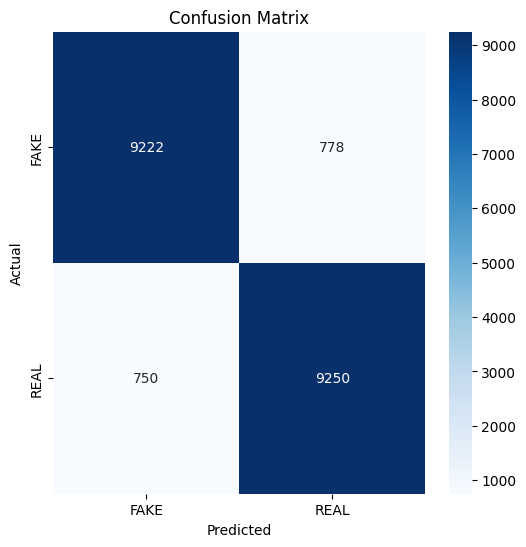

In [14]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Compute classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.92      0.92      0.92     10000
        REAL       0.92      0.93      0.92     10000

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



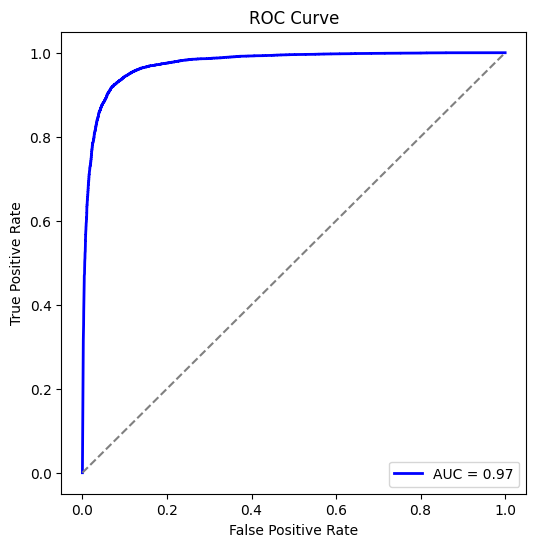

In [16]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [17]:
# Print metrics
accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {roc_auc:.4f}")

Accuracy: 0.9236
AUC: 0.9743


In [18]:
model.save('Pure_ResNet.h5')
model.save('Pure_ResNet.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
